# Предобработка данных

Загрузим все необходимы нам таблицы из базы данных.
- База данных - PostgreSQL.
- Программа для обработки историй раздач - PokerTracker

In [1]:
import psycopg2 #A Python driver for PostgreSQL
import pandas as pd
import matplotlib.pyplot as pltpd
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def connect_database(name='PT4_tournament'):

    conn = psycopg2.connect("dbname="+name+" user=postgres")
    cur = conn.cursor()
    return cur, conn

cur, conn = connect_database()

### Группы рук по силе

In [3]:
sql_lookup_hand_groups = "\
SELECT * \
FROM lookup_hand_groups"

In [4]:
lookup_hand_groups = pd.read_sql(sql_lookup_hand_groups, conn)

In [5]:
lookup_hand_groups

,id_group,group_name
0,1,Straight Flush
1,2,Four of a Kind
2,3,Full House
3,4,Flush
4,5,Straight
5,6,Three of a Kind
6,7,Two Pair
7,8,One Pair
8,9,High Card


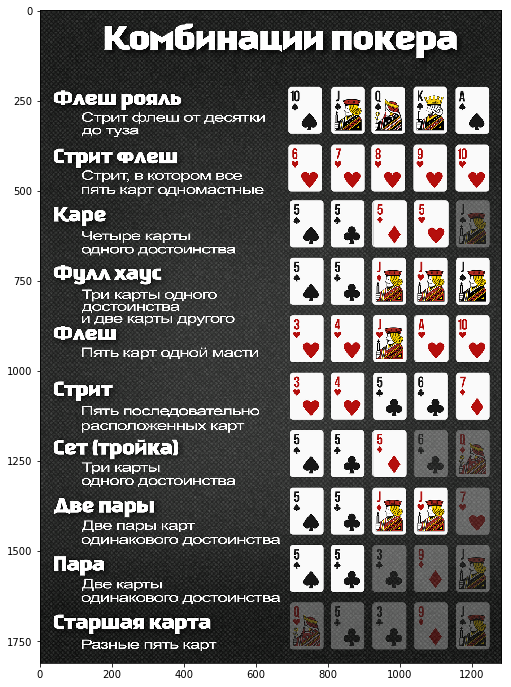

In [6]:
plt.figure(figsize=(20, 12))
img = mpimg.imread('pictures\\hand_groups.png')
plt.imshow(img);

### Действия 
Таблица всевозможных действий:
- F - fold (выбросить карты / фолд)
- С - call (поддержать ставку / кол)
- X - check (пропустить торги / чек)
- R - raise (поднять ставку / рейз)
- B - bet (сделать ставку / бет)
- все остальные - это комбинации всевозможных действий, например,
CC - call/call, означает, что игрок сделал кол, а за ним кто-то поднял ставку и он вновь сделал кол.

In [7]:
sql_lookup_actions = "\
SELECT * \
FROM lookup_actions"

In [8]:
lookup_actions = pd.read_sql(sql_lookup_actions, conn)

In [9]:
lookup_actions.head(10)

,id_action,action
0,0,
1,1,C
2,2,B
3,3,X
4,4,F
5,5,R
6,6,RC
7,7,XF
8,8,BF
9,9,CC


### Группы рук по силе (расширенная версия)
В данной таблице идет детализация сил комбинаций выиграша, например, у двух игроков по две пары, но у одного это короли плюс десятки, а другого короли плюс девятки. По правилам выигрывает первый.

In [10]:
sql_lookup_hand_ranks = "\
SELECT * \
FROM lookup_hand_ranks"

In [11]:
lookup_hand_ranks = pd.read_sql(sql_lookup_hand_ranks, conn)

In [12]:
lookup_hand_ranks.head()

,id_hand_rank,id_group,group_name,group_details
0,1,1,Straight Flush,Royal Flush
1,2,1,Straight Flush,King High
2,3,1,Straight Flush,Queen High
3,4,1,Straight Flush,Jack High
4,5,1,Straight Flush,Ten High


In [13]:
lookup_hand_ranks.tail()

,id_hand_rank,id_group,group_name,group_details
309,310,9,High Card,Seven
310,311,9,High Card,Six
311,312,9,High Card,Five
312,313,9,High Card,Four
313,314,9,High Card,Three


### Позиции
- UTG - первая позиция (игрок принимает решение первым на префлопе) может выбрать кол/фолд/рейз.
- UTG+1 - принимает решение после UTG
- UTG+2 - принимает решение после UTG+1
- MP - принимает решение после UTG+2
- MP+1 - принимает решение после MP
- MP+2 - принимает решение после MP+1
- CO - принимает решение после MP+2
- BUTTON - принимает решение после CO
- SB - принимает решение после BUTTON. На префлопе вносит ставку 0.5 большого блайнда (на флопе и на последующих улицах принимает решение первым)
- BB - принимает решение после SB. На префлопе вносит ставку 1 большой блайнда (на флопе и на последующих улицах принимает решение вторым)

In [14]:
sql_lookup_positions = "\
SELECT * \
FROM lookup_positions"

In [15]:
lookup_positions = pd.read_sql(sql_lookup_positions, conn)

In [16]:
lookup_positions.head()

,cnt_players,position,absolute_position,description,flg_sb,flg_bb,flg_ep,flg_mp,flg_co,flg_btn
0,2,0,0,BUTTON,False,False,False,False,False,True
1,2,1,1,CO,False,False,False,False,True,False
2,2,8,8,BB,False,True,False,False,False,False
3,2,9,9,SB,True,False,False,False,False,False
4,3,0,0,BUTTON,False,False,False,False,False,True


In [17]:
lookup_positions.shape

(69, 10)

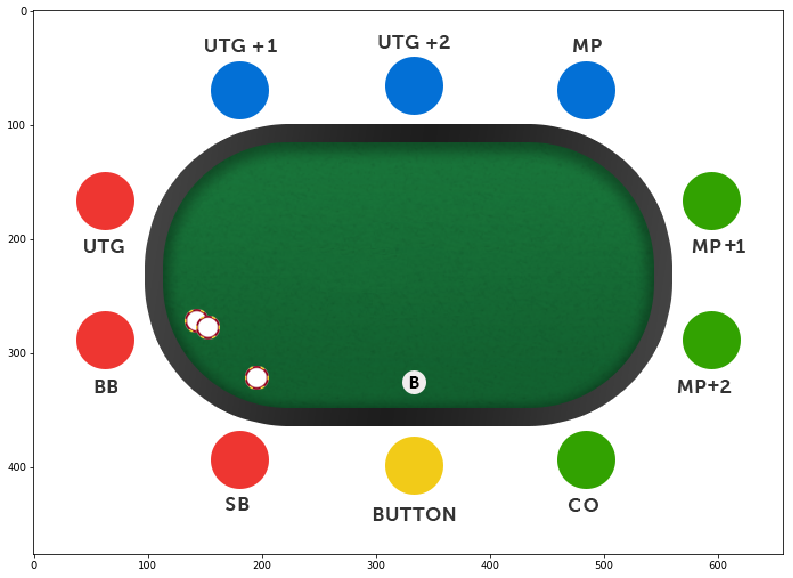

In [18]:
plt.figure(figsize=(16, 10))
img = mpimg.imread('pictures\\positions.png')
plt.imshow(img);

### Карты
Все варианты карт, которые могут быть у игроков. 

In [19]:
sql_lookup_hole_cards = "\
SELECT * \
FROM lookup_hole_cards"

In [20]:
lookup_hole_cards = pd.read_sql(sql_lookup_hole_cards, conn)

In [21]:
lookup_hole_cards.head()

,id_holecard,id_gametype,hole_cards,enum_pair_type,val_pair_1,val_pair_2,flg_h_suited,flg_h_connector,flg_h_1_gap,flg_h_2_gap,flg_o_connector,flg_o_connector_2_str,flg_o_connector_2_gap,flg_o_connector_3
0,1,1,AA,1,14,0,False,False,False,False,False,False,False,False
1,2,1,AKs,N,0,0,True,True,False,False,False,False,False,False
2,3,1,AKo,N,0,0,False,True,False,False,False,False,False,False
3,4,1,AQs,N,0,0,True,False,True,False,False,False,False,False
4,5,1,AQo,N,0,0,False,False,True,False,False,False,False,False


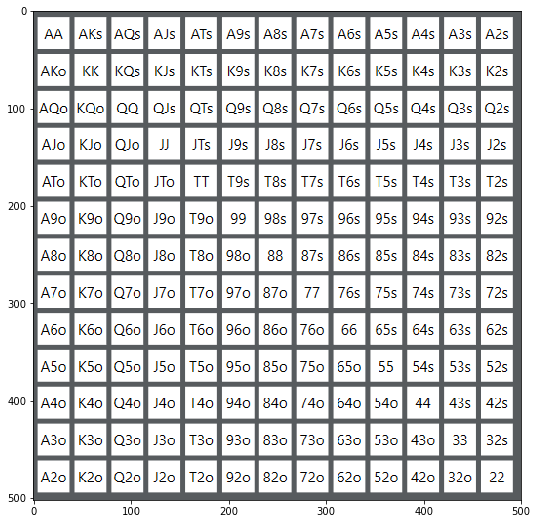

In [22]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures\\cards.png')
plt.imshow(img);

## Все раздачи (информация по каждой руке)
Загрузим из БД все руки. Одна строка - один полный раунд игры от префлопа до ривера(если дошла торговля). 
Содержание таблицы (основные поля):
- id hand (руки)
- id_blinds (блайнды, какой размер большого и малого блайнда в текущей раздаче)
- card_1, card_2, card_3 - карты на флопе
- card_4 - карта на терне
- card_5 - карта на ривере

In [23]:
sql_tourney_hand_summary = "\
SELECT * \
FROM tourney_hand_summary \
ORDER BY id_hand"

In [24]:
tourney_hand_summary = pd.read_sql(sql_tourney_hand_summary, conn)

In [25]:
tourney_hand_summary.head()

,id_hand,id_gametype,id_site,id_tourney,id_blinds,id_table,hand_no,date_played,date_imported,cnt_players,...,id_winner_lo,button,card_1,card_2,card_3,card_4,card_5,flg_note,flg_tag,flg_autonote
0,1,1,100,1,1,1,154269611526,2016-06-04 11:01:47,2018-03-11 15:46:13,6,...,-1,6,15,27,29,0,0,False,False,False
1,2,1,100,1,2,1,154269636110,2016-06-04 11:02:40,2018-03-11 15:46:13,6,...,-1,1,0,0,0,0,0,False,False,False
2,3,1,100,1,2,1,154269645332,2016-06-04 11:03:01,2018-03-11 15:46:13,6,...,-1,2,43,23,31,29,19,False,False,False
3,4,1,100,1,2,1,154269659875,2016-06-04 11:03:32,2018-03-11 15:46:13,6,...,-1,3,0,0,0,0,0,False,False,False
4,5,1,100,1,2,2,154269688671,2016-06-04 11:04:33,2018-03-11 15:46:13,5,...,-1,4,0,0,0,0,0,False,False,False


In [26]:
tourney_hand_summary.shape

(122225, 41)

## Игровая ситуация с точки зрения одного игрока
Одна строка - один игрок и вся статистика по одной раздаче лицом этого игрока.
Загрузим одну строку, чтобы посмотреть общую структуру таблицы.

In [27]:
sql_tourney_hand_player_statistics_1 = "\
SELECT * \
FROM tourney_hand_player_statistics \
ORDER BY id_hand \
LIMIT 1"

In [28]:
sql_tourney_hand_player_statistics_1

'SELECT * FROM tourney_hand_player_statistics ORDER BY id_hand LIMIT 1'

In [29]:
tourney_hand_player_statistics_1 = pd.read_sql(sql_tourney_hand_player_statistics_1, conn)

In [30]:
tourney_hand_player_statistics_1

,id_hand,id_gametype,id_player,id_player_real,id_holecard,id_blinds,id_tourney,date_played,position,cnt_players,...,val_r_2bet_facing_pct,amt_r_3bet_facing,val_r_3bet_facing_pct,amt_r_4bet_facing,val_r_4bet_facing_pct,val_r_raise_aggressor_pos,amt_r_raise_made,val_r_raise_made_pct,amt_r_raise_made_2,val_r_raise_made_2_pct
0,1,1,1,1,0,1,1,2016-06-04 11:01:47,9,6,...,0.0,0.0,0.0,0.0,0.0,-1,0.0,0.0,0.0,0.0


## Выберем важные поля для первичного анализа:
- id hand (руки) для связи с нашей первой таблицей (tourney_hand_summary)
- id_holecard для связи с таблицей карт (sql_lookup_hole_cards) 
- id_blinds для того, чтобы знать какой размер большого и малого блайнда в текущей раздаче
- position для связи с таблицей (lookup_positions), чтобы знать текущую позицию игрока
- amt_expected_won ожидаемый выиграш игрока в данной раздаче (ЭТО ОСНОВНОЙ ПОКАЗАТЕЛЬ ПРИБЫЛИ) 
- id_action_p для связи с таблицей (lookup_actions), так мы узнаем действия конкретного игрока на префлопе
- amt_before размер стека (количество фишек у игрока) перед началом раздачи
- amt_bet_p размер ставки на префлопе

In [31]:
sql_tourney_hand_player_statistics = "\
SELECT id_hand, id_gametype, id_player, id_holecard, id_blinds, id_tourney, position, cnt_players, \
cnt_players_lookup_position, flg_p_first_raise, flg_p_limp, flg_p_fold, flg_p_ccall, enum_allin, \
amt_won, amt_expected_won, val_equity, id_action_p, id_action_f, id_action_t, id_action_r, amt_blind, \
amt_bet_p, amt_bet_f, amt_bet_t, amt_bet_r, amt_bet_ttl, flg_p_open, flg_p_open_opp, amt_p_effective_stack, \
amt_p_raise_facing, val_p_raise_facing_pct, amt_p_2bet_facing, amt_p_raise_made, amt_p_raise_facing, amt_before \
FROM tourney_hand_player_statistics \
ORDER BY id_hand"

In [32]:
tourney_hand_player_statistics = pd.read_sql(sql_tourney_hand_player_statistics, conn)

In [33]:
tourney_hand_player_statistics.head(10)

,id_hand,id_gametype,id_player,id_holecard,id_blinds,id_tourney,position,cnt_players,cnt_players_lookup_position,flg_p_first_raise,...,amt_bet_ttl,flg_p_open,flg_p_open_opp,amt_p_effective_stack,amt_p_raise_facing,val_p_raise_facing_pct,amt_p_2bet_facing,amt_p_raise_made,amt_p_raise_facing,amt_before
0,1,1,1,0,1,1,9,6,6,False,...,200.0,True,True,3144.0,0.0,0.0,0.0,0.0,0.0,3184.0
1,1,1,2,0,1,1,8,6,6,False,...,200.0,False,False,3144.0,0.0,0.0,0.0,0.0,0.0,5702.0
2,1,1,4,78,1,1,2,6,6,False,...,40.0,False,True,2960.0,0.0,0.0,0.0,0.0,0.0,3000.0
3,1,1,5,0,1,1,1,6,6,False,...,40.0,False,True,4958.0,0.0,0.0,0.0,0.0,0.0,4998.0
4,1,1,3,0,1,1,3,6,6,False,...,40.0,False,True,3995.0,0.0,0.0,0.0,0.0,0.0,4035.0
5,1,1,6,0,1,1,0,6,6,False,...,40.0,False,True,5662.0,0.0,0.0,0.0,0.0,0.0,6865.0
6,2,1,2,0,2,1,9,6,6,False,...,250.0,True,True,3945.0,0.0,0.0,0.0,0.0,0.0,5502.0
7,2,1,3,0,2,1,8,6,6,False,...,250.0,False,False,3945.0,0.0,0.0,0.0,0.0,0.0,3995.0
8,2,1,4,51,2,1,3,6,6,False,...,50.0,False,True,2910.0,0.0,0.0,0.0,0.0,0.0,2960.0
9,2,1,5,0,2,1,2,6,6,False,...,50.0,False,True,4908.0,0.0,0.0,0.0,0.0,0.0,4958.0


In [34]:
tourney_hand_player_statistics.shape

(836453, 36)

#### Отберем только необходимы столбцы в таблице позиций
Для точного определения, где находится игрок, нам необходимо знать номер его позиции (0, 1, 8, 9 и т.д.), а также количество человек за столом (их может быть от 2 до 9).

In [35]:
positions = lookup_positions[['cnt_players', 'position', 'description']]

In [36]:
positions.head()

,cnt_players,position,description
0,2,0,BUTTON
1,2,1,CO
2,2,8,BB
3,2,9,SB
4,3,0,BUTTON


Переименуем некоторые столбцы, содержащие знак +.

In [37]:
positions['description'] = positions['description'].map({'UTG' : 'UTG',
                                                         'UTG+1' : 'UTG_1', 
                                                         'MP' : 'MP', 
                                                         'MP+1' : 'MP_1',
                                                         'MP+2' : 'MP_2',
                                                         'CO' : 'CO',
                                                         'BUTTON' : 'BUTTON',
                                                         'SB' : 'SB',
                                                         'BB' : 'BB'})

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Оставим в таблице id_gametype равный 1, это показатель отвечает за вид покера - Холдем.

In [38]:
lookup_hole_cards = lookup_hole_cards[lookup_hole_cards.id_gametype == 1]

Добавим в общую таблицу позиции игроков

In [39]:
df = pd.merge(tourney_hand_player_statistics, positions, on=['cnt_players', 'position'],
                      how='left', sort=False) 

Добавим в общую таблицу действия игроков

In [40]:
df = pd.merge(df, lookup_actions, how = 'left',  left_on = 'id_action_p', right_on = 'id_action')

Добавим в общую таблицу карты игроков

In [41]:
df = pd.merge(df, lookup_hole_cards[['id_holecard', 'hole_cards']], how = 'left',  on='id_holecard')

In [42]:
df.rename(index=str, columns={"action": "action_p"}, inplace=True)

In [43]:
df.head()

,id_hand,id_gametype,id_player,id_holecard,id_blinds,id_tourney,position,cnt_players,cnt_players_lookup_position,flg_p_first_raise,...,amt_p_raise_facing,val_p_raise_facing_pct,amt_p_2bet_facing,amt_p_raise_made,amt_p_raise_facing,amt_before,description,id_action,action_p,hole_cards
0,1,1,1,0,1,1,9,6,6,False,...,0.0,0.0,0.0,0.0,0.0,3184.0,SB,1,C,NaN
1,1,1,2,0,1,1,8,6,6,False,...,0.0,0.0,0.0,0.0,0.0,5702.0,BB,3,X,NaN
2,1,1,4,78,1,1,2,6,6,False,...,0.0,0.0,0.0,0.0,0.0,3000.0,MP,4,F,J7o
3,1,1,5,0,1,1,1,6,6,False,...,0.0,0.0,0.0,0.0,0.0,4998.0,CO,4,F,NaN
4,1,1,3,0,1,1,3,6,6,False,...,0.0,0.0,0.0,0.0,0.0,4035.0,UTG,4,F,NaN


### Структура блайндов
Дополнительно загрузим таблицу структуры блайндов для того, чтобы знать какой размер блайндов был в каждой раздаче.

In [44]:
sql_tourney_blinds = "\
SELECT * \
FROM tourney_blinds \
ORDER BY id_blinds"

In [45]:
tourney_blinds = pd.read_sql(sql_tourney_blinds, conn)

In [46]:
blinds = tourney_blinds[['id_blinds', 'id_gametype', 'amt_sb', 'amt_bb']]

In [47]:
blinds.head()

,id_blinds,id_gametype,amt_sb,amt_bb
0,1,1,80.0,160.0
1,2,1,100.0,200.0
2,3,1,125.0,250.0
3,4,1,150.0,300.0
4,5,1,200.0,400.0


Свяжем наши таблицы - основную и структура блайндов.

In [48]:
df = pd.merge(df, blinds, how = 'left',  on='id_blinds')

In [49]:
df.head()

,id_hand,id_gametype_x,id_player,id_holecard,id_blinds,id_tourney,position,cnt_players,cnt_players_lookup_position,flg_p_first_raise,...,amt_p_raise_made,amt_p_raise_facing,amt_before,description,id_action,action_p,hole_cards,id_gametype_y,amt_sb,amt_bb
0,1,1,1,0,1,1,9,6,6,False,...,0.0,0.0,3184.0,SB,1,C,NaN,1,80.0,160.0
1,1,1,2,0,1,1,8,6,6,False,...,0.0,0.0,5702.0,BB,3,X,NaN,1,80.0,160.0
2,1,1,4,78,1,1,2,6,6,False,...,0.0,0.0,3000.0,MP,4,F,J7o,1,80.0,160.0
3,1,1,5,0,1,1,1,6,6,False,...,0.0,0.0,4998.0,CO,4,F,NaN,1,80.0,160.0
4,1,1,3,0,1,1,3,6,6,False,...,0.0,0.0,4035.0,UTG,4,F,NaN,1,80.0,160.0


Переведем стеки игроков в большие блайнды. Важная операция для того, чтобы привести к единым значениям стеки игроков. Например, стек может быть 10000 и большой блайнд = 1000, то есть размер будет равен 10ББ, а в другой раздаче стек будет равен 1000 и большой блайнд будет равен 100, то есть размер в больших блайндах будет 10ББ. Итог - стеки равны.

In [50]:
df['amt_before_bb'] = round(df.amt_before / df.amt_bb, 2)

## Уберем лишние колонки из истории рук
Оставим важные столбцы и будем продолжать работу с ними.

In [51]:
tourney_hand_summary.head()

,id_hand,id_gametype,id_site,id_tourney,id_blinds,id_table,hand_no,date_played,date_imported,cnt_players,...,id_winner_lo,button,card_1,card_2,card_3,card_4,card_5,flg_note,flg_tag,flg_autonote
0,1,1,100,1,1,1,154269611526,2016-06-04 11:01:47,2018-03-11 15:46:13,6,...,-1,6,15,27,29,0,0,False,False,False
1,2,1,100,1,2,1,154269636110,2016-06-04 11:02:40,2018-03-11 15:46:13,6,...,-1,1,0,0,0,0,0,False,False,False
2,3,1,100,1,2,1,154269645332,2016-06-04 11:03:01,2018-03-11 15:46:13,6,...,-1,2,43,23,31,29,19,False,False,False
3,4,1,100,1,2,1,154269659875,2016-06-04 11:03:32,2018-03-11 15:46:13,6,...,-1,3,0,0,0,0,0,False,False,False
4,5,1,100,1,2,2,154269688671,2016-06-04 11:04:33,2018-03-11 15:46:13,5,...,-1,4,0,0,0,0,0,False,False,False


In [52]:
tourney_hand_summary.columns

Index(['id_hand', 'id_gametype', 'id_site', 'id_tourney', 'id_blinds',
       'id_table', 'hand_no', 'date_played', 'date_imported', 'cnt_players',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'flg_note', 'flg_tag', 'flg_autonote'],
      dtype='object')

In [53]:
tourney_hand_summary = tourney_hand_summary[['id_hand', 'id_blinds', 'id_table', 'hand_no', 'cnt_players',
                                             'id_table', 'cnt_players', 'cnt_players_lookup_position',
                                             'cnt_players_f', 'cnt_players_t', 'cnt_players_r', 'amt_pot',
                                             'amt_short_stack', 'amt_pot_p', 'amt_pot_f', 'amt_pot_t',
                                             'amt_pot_r', 'str_actors_p', 'str_actors_f', 'str_actors_t',
                                             'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
                                             'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
                                             'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
                                             'card_4', 'card_5']]

In [54]:
tourney_hand_summary.head()

,id_hand,id_blinds,id_table,hand_no,cnt_players,id_table,cnt_players,cnt_players_lookup_position,cnt_players_f,cnt_players_t,...,id_win_hand,id_win_hand_lo,id_winner,id_winner_lo,button,card_1,card_2,card_3,card_4,card_5
0,1,1,1,154269611526,6,1,6,6,2,0,...,0,0,1,-1,6,15,27,29,0,0
1,2,2,1,154269636110,6,1,6,6,0,0,...,0,0,2,-1,1,0,0,0,0,0
2,3,2,1,154269645332,6,1,6,6,2,2,...,293,0,1,-1,2,43,23,31,29,19
3,4,2,1,154269659875,6,1,6,6,0,0,...,0,0,1,-1,3,0,0,0,0,0
4,5,2,2,154269688671,5,2,5,5,0,0,...,0,0,7,-1,4,0,0,0,0,0


In [55]:
tourney_hand_summary.shape

(122225, 35)

In [56]:
del df['id_gametype_x']

In [57]:
df.shape

(836453, 43)

In [58]:
df.head()

,id_hand,id_player,id_holecard,id_blinds,id_tourney,position,cnt_players,cnt_players_lookup_position,flg_p_first_raise,flg_p_limp,...,amt_p_raise_facing,amt_before,description,id_action,action_p,hole_cards,id_gametype_y,amt_sb,amt_bb,amt_before_bb
0,1,1,0,1,1,9,6,6,False,True,...,0.0,3184.0,SB,1,C,NaN,1,80.0,160.0,19.90
1,1,2,0,1,1,8,6,6,False,False,...,0.0,5702.0,BB,3,X,NaN,1,80.0,160.0,35.64
2,1,4,78,1,1,2,6,6,False,False,...,0.0,3000.0,MP,4,F,J7o,1,80.0,160.0,18.75
3,1,5,0,1,1,1,6,6,False,False,...,0.0,4998.0,CO,4,F,NaN,1,80.0,160.0,31.24
4,1,3,0,1,1,3,6,6,False,False,...,0.0,4035.0,UTG,4,F,NaN,1,80.0,160.0,25.22


Зафиксируем позиции по порядку начиная с первой(UTG) и последней(BB)

In [59]:
name_positions = ['id_hand', 'UTG', 'UTG_1', 'MP', 'MP_1', 'MP_2', 'CO', 'BUTTON', 'SB', 'BB']

Создадим сводную таблицу стеков по позициям

In [60]:
pivot_stack = df.pivot_table(index=['id_hand'],
                             columns='description',
                             values='amt_before_bb',
                             aggfunc='sum',
                             fill_value=0).reset_index()

In [61]:
pivot_stack = pivot_stack[name_positions]

Так как у нас по позициям будет гораздо больше столбцов, необходимо переименовать столбцы

In [62]:
pivot_stack.columns = ['id_hand', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb',
                       'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb']

In [63]:
pivot_stack.head()

,id_hand,UTG_bb,UTG_1_bb,MP_bb,MP_1_bb,MP_2_bb,CO_bb,BUTTON_bb,SB_bb,BB_bb
0,1,25.22,0.0,18.75,0.0,0.0,31.24,42.91,19.90,35.64
1,2,14.80,0.0,24.79,0.0,0.0,34.12,17.72,27.51,19.98
2,3,24.54,0.0,33.88,0.0,0.0,17.47,29.76,18.73,14.55
3,4,16.40,0.0,37.44,0.0,0.0,29.51,17.98,13.30,24.29
4,5,29.52,0.0,0.00,0.0,0.0,12.55,52.55,13.75,10.35


Добавим полученную сводную таблицу в основную для дальнейшего анализа

In [64]:
tourney_hand_summary = pd.merge(tourney_hand_summary, pivot_stack, on='id_hand')

Далее сделаем сводную таблицу с картами игроков по позициям

In [65]:
pivot_card = df.pivot_table(index=['id_hand'],
                            columns='description',
                            values='hole_cards',
                            aggfunc=lambda x: ' '.join(str(v) for v in x), 
                            fill_value='unknown').reset_index()

In [66]:
pivot_card = pivot_card[name_positions]

In [67]:
pivot_card.columns = ['id_hand', 'UTG_card', 'UTG_1_card', 'MP_card', 'MP_1_card',
                      'MP_2_card', 'CO_card', 'BUTTON_card', 'SB_card', 'BB_card']

In [68]:
pivot_card.head()

,id_hand,UTG_card,UTG_1_card,MP_card,MP_1_card,MP_2_card,CO_card,BUTTON_card,SB_card,BB_card
0,1,nan,unknown,J7o,unknown,unknown,nan,nan,nan,nan
1,2,QJo,unknown,nan,unknown,unknown,nan,nan,nan,nan
2,3,nan,unknown,A9o,unknown,unknown,AJo,nan,nan,J2o
3,4,nan,unknown,nan,unknown,unknown,nan,nan,A3s,nan
4,5,nan,unknown,unknown,unknown,unknown,53o,nan,nan,nan


Добавим полученную сводную таблицу в основную для дальнейшего анализа

In [69]:
tourney_hand_summary = pd.merge(tourney_hand_summary, pivot_card, on='id_hand')

Действия игроков по позициям

In [70]:
pivot_action_p = df.pivot_table(index=['id_hand'],
                                columns='description',
                                values='action_p',
                                aggfunc=lambda x: ' '.join(str(v) for v in x)).reset_index()

In [71]:
pivot_action_p = pivot_action_p[name_positions]

In [72]:
pivot_action_p.columns = ['id_hand', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p', 'MP_1_act_p',
                          'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p', 'BB_act_p']

Добавим полученную сводную таблицу в основную для дальнейшего анализа

In [73]:
tourney_hand_summary = pd.merge(tourney_hand_summary, pivot_action_p, on='id_hand')

Переведем показатели в большие блайнды

In [74]:
df['amt_won_bb'] = round(df.amt_won // df.amt_bb, 2)
df['amt_bet_p_bb'] = round(df.amt_bet_p // df.amt_bb, 2)
df['amt_expected_won_bb'] = round(df.amt_expected_won // df.amt_bb, 2)

In [75]:
pivot_amt_bet_p_bb = df.pivot_table(index=['id_hand'],
                                    columns='description',
                                    values='amt_bet_p_bb',
                                    aggfunc=sum).reset_index()

In [76]:
pivot_amt_won_bb = df.pivot_table(index=['id_hand'],
                                  columns='description',
                                  values='amt_won_bb',
                                  aggfunc=sum).reset_index()

In [77]:
pivot_amt_expected_bb = df.pivot_table(index=['id_hand'],
                                       columns='description',
                                       values='amt_expected_won_bb',
                                       aggfunc=sum).reset_index()

In [78]:
pivot_amt_bet_p_bb = pivot_amt_bet_p_bb[name_positions]
pivot_amt_won_bb = pivot_amt_won_bb[name_positions]
pivot_amt_expected_bb = pivot_amt_expected_bb[name_positions]

In [79]:
pivot_amt_bet_p_bb.columns = ['id_hand', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b_p', 'MP_1_amt_b_p',
                              'MP_2_amt_b_p', 'CO_amt_b_p', 'BUTTON_amt_b_p', 'SB_amt_b_p', 'BB_amt_b_p']
pivot_amt_won_bb.columns = ['id_hand', 'UTG_amt_w', 'UTG_1_amt_w', 'MP_amt_w', 'MP_1_amt_w',
                            'MP_2_amt_w', 'CO_amt_w', 'BUTTON_amt_w', 'SB_amt_w', 'BB_amt_w']
pivot_amt_expected_bb.columns = ['id_hand', 'UTG_amt_exp', 'UTG_1_amt_exp', 'MP_amt_exp', 'MP_1_amt_exp',
                                 'MP_2_amt_exp', 'CO_amt_exp', 'BUTTON_amt_exp', 'SB_amt_exp', 'BB_amt_exp']

In [80]:
tourney_hand_summary = pd.merge(tourney_hand_summary, pivot_amt_bet_p_bb, on='id_hand')

In [81]:
tourney_hand_summary = pd.merge(tourney_hand_summary, pivot_amt_won_bb, on='id_hand')

In [82]:
tourney_hand_summary = pd.merge(tourney_hand_summary, pivot_amt_expected_bb, on='id_hand')

In [83]:
tourney_hand_summary.head()

,id_hand,id_blinds,id_table,hand_no,cnt_players,id_table,cnt_players,cnt_players_lookup_position,cnt_players_f,cnt_players_t,...,BB_amt_w,UTG_amt_exp,UTG_1_amt_exp,MP_amt_exp,MP_1_amt_exp,MP_2_amt_exp,CO_amt_exp,BUTTON_amt_exp,SB_amt_exp,BB_amt_exp
0,1,1,1,154269611526,6,1,6,6,2,0,...,-2.0,-1.0,NaN,-1.0,NaN,NaN,-1.0,-1.0,2.0,-2.0
1,2,2,1,154269636110,6,1,6,6,0,0,...,-2.0,-1.0,NaN,-1.0,NaN,NaN,-1.0,-1.0,2.0,-2.0
2,3,2,1,154269645332,6,1,6,6,2,2,...,-2.0,-1.0,NaN,-8.0,NaN,NaN,10.0,-1.0,-1.0,-2.0
3,4,2,1,154269659875,6,1,6,6,0,0,...,-2.0,-1.0,NaN,2.0,NaN,NaN,-1.0,-1.0,-1.0,-2.0
4,5,2,2,154269688671,5,2,5,5,0,0,...,1.0,-1.0,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,1.0


In [84]:
tourney_hand_summary.replace(['nan', None], 0, inplace=True)

## Сохраним полученную таблицу для дальнейшего анализа

In [88]:
tourney_hand_summary.to_csv('input\\tourney_hand_summary_03_18_18.csv')